In [84]:
%load_ext autoreload
%autoreload 2
import intervention_SR as isr
import numpy as np
import matplotlib.pyplot as plt
from SRtools import SR_hetro as srh
from SRtools import presets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
my_presets = ['yeast','celegance','Mice_F','Mice_M','Labradors','Jack Russell','Humans_M']
time_units ={
    'yeast':'generations',
    'celegance':'days',
    'Mice_F':'days',
    'Mice_M':'days',
    'Labradors':'years',
    'Jack Russell':'years',
    'Humans_M':'years'
}
time_convert ={
    'generations':3/24,
    'days':1,
    'years':365
}
factor =1.5

# Damage removal
removing a 0.1% damge every loop iteration

In [86]:

# For each preset, save ML and remaining lifespan ratios for a single 1% damage removal intervention at ML/2
percent = 0.001
beta_etas = {}
MLs_vs_intervention = {}
remaining_lifespan_ratios_medians = {}
remaining_lifespan_ratios_means = {}

for preset in my_presets:
    config = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config['time_step_multiplier'] = int(np.ceil(config['time_step_multiplier'] / 5))
    theta = presets.getTheta(preset)
    beta_eta = theta[1] / theta[0]
    # Get baseline ML
    sim = isr.getInterventionSR(
        theta,
        parallel=True,
        nsteps=config['nsteps'],
        time_step_multiplier=config['time_step_multiplier'],
        npeople=config['npeople'],
        t_end=config['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML = sim.getMedianLifetime()
    beta_etas[preset] = beta_eta / ML

    # Only one intervention time: ML/2
    t_int = 0.5 * ML
    MLs = []
    remaining_lifespan_ratios_medians[preset] = []
    remaining_lifespan_ratios_means[preset] = []
    # print(config['nsteps'])
    sim_int = isr.getInterventionSR(
        theta,
        parallel=True,
        nsteps=int(5000*factor),
        time_step_multiplier=config['time_step_multiplier'],
        npeople=config['npeople'],
        t_end=config['t_end']*factor,
        intervention_time=t_int,
        intervention_duration=[0,config['t_end']*factor],
        intervention_type='Damage removal',
        intervention_effect=percent
    )
    stats = sim.remaining_lifetime_at_age(age=t_int, types=['median', 'mean'])
    stats_int = sim_int.remaining_lifetime_at_age(age=t_int, types=['median', 'mean'])
    remaining_lifespan_ratios_medians[preset].append(stats_int['median'] / stats['median'])
    remaining_lifespan_ratios_means[preset].append(stats_int['mean'] / stats['mean'])
    MLs.append(sim_int.getMedianLifetime())

    MLs_vs_intervention[preset] = sim_int.getMedianLifetime()/ML
    remaining_lifespan_ratios_medians[preset] = np.array(remaining_lifespan_ratios_medians[preset])
    remaining_lifespan_ratios_means[preset] = np.array(remaining_lifespan_ratios_means[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [87]:
print(beta_etas)
print(MLs_vs_intervention)

{'yeast': 0.014539797430083145, 'celegance': 0.3950961661341853, 'Mice_F': 1.0219692805820828, 'Mice_M': 0.5772087065481003, 'Labradors': 1.3540763092679389, 'Jack Russell': 2.151048388170529, 'Humans_M': 1.424635170830474}
{'yeast': 1.6893053465329768, 'celegance': 1.3636606073568063, 'Mice_F': 1.0688236830849842, 'Mice_M': 1.3669258299381981, 'Labradors': 1.0096995289353012, 'Jack Russell': 1.0059624671893748, 'Humans_M': 1.0002290752047034}


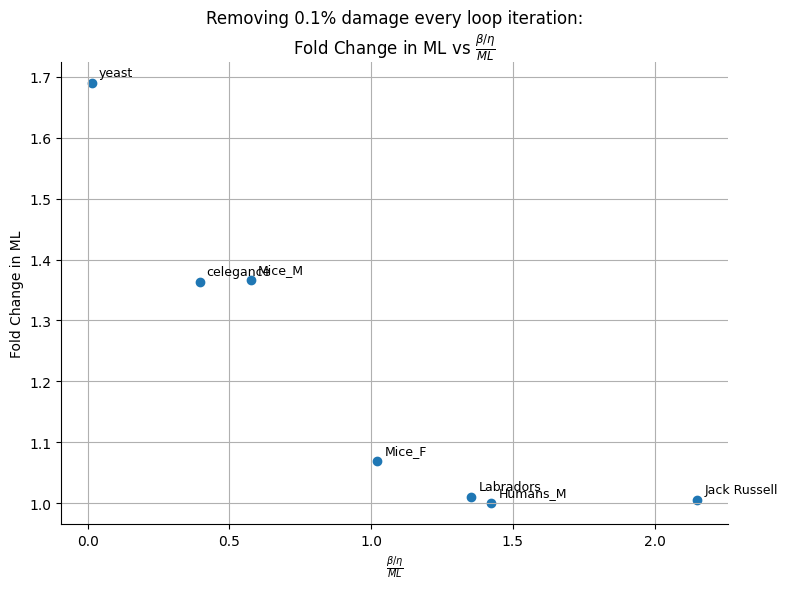

In [88]:
import matplotlib.pyplot as plt

# Prepare data for plotting
x = []
y = []
labels = []

for preset in MLs_vs_intervention:
    x.append(beta_etas[preset])
    y.append(MLs_vs_intervention[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C0')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title(f'Removing {percent*100}% damage every loop iteration:\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


# Beta change
Changing beta by 5%

In [89]:

# For each preset, save ML and remaining lifespan ratios for a single 5% beta change intervention at ML/2
beta_change_percent = 0.05
beta_eta_ratios = {}
MLs_vs_beta_change = {}
remaining_lifespan_ratios_medians_beta = {}
remaining_lifespan_ratios_means_beta = {}

for preset in my_presets:
    config_beta = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_beta['time_step_multiplier'] = int(np.ceil(config_beta['time_step_multiplier'] / 5))
    theta_beta = presets.getTheta(preset)
    beta_eta_ratio = theta_beta[1] / theta_beta[0]
    # Get baseline ML
    sim_beta = isr.getInterventionSR(
        theta_beta,
        parallel=True,
        nsteps=config_beta['nsteps'],
        time_step_multiplier=config_beta['time_step_multiplier'],
        npeople=config_beta['npeople'],
        t_end=config_beta['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_beta = sim_beta.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_beta

    # Only one intervention time: ML/2
    t_int_beta = 0.5 * ML_beta
    MLs_beta = []
    remaining_lifespan_ratios_medians_beta[preset] = []
    remaining_lifespan_ratios_means_beta[preset] = []

    sim_int_beta = isr.getInterventionSR(
        theta_beta,
        parallel=True,
        nsteps=int(config_beta['nsteps']*factor),
        time_step_multiplier=config_beta['time_step_multiplier'],
        npeople=config_beta['npeople'],
        t_end=config_beta['t_end']*factor,
        intervention_time=t_int_beta,
        intervention_duration=[0, config_beta['t_end']*factor],
        intervention_type='Beta change',
        intervention_effect=beta_change_percent
    )
    stats_beta = sim_beta.remaining_lifetime_at_age(age=t_int_beta, types=['median', 'mean'])
    stats_int_beta = sim_int_beta.remaining_lifetime_at_age(age=t_int_beta, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_beta[preset].append(stats_int_beta['median'] / stats_beta['median'])
    remaining_lifespan_ratios_means_beta[preset].append(stats_int_beta['mean'] / stats_beta['mean'])
    MLs_beta.append(sim_int_beta.getMedianLifetime())

    MLs_vs_beta_change[preset] = sim_int_beta.getMedianLifetime() / ML_beta
    remaining_lifespan_ratios_medians_beta[preset] = np.array(remaining_lifespan_ratios_medians_beta[preset])
    remaining_lifespan_ratios_means_beta[preset] = np.array(remaining_lifespan_ratios_means_beta[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [90]:
print(beta_eta_ratios)
print(MLs_vs_beta_change)

{'yeast': 0.014601603157734932, 'celegance': 0.3933368320610687, 'Mice_F': 1.0233654134790529, 'Mice_M': 0.5835775807110749, 'Labradors': 1.3635273494976008, 'Jack Russell': 2.1621295465338317, 'Humans_M': 1.4259003885665578}
{'yeast': 1.0009959528433052, 'celegance': 1.017437104970951, 'Mice_F': 1.0453537930740493, 'Mice_M': 1.030581056087413, 'Labradors': 1.0649670590596514, 'Jack Russell': 1.0890182933482042, 'Humans_M': 1.0656483031366881}


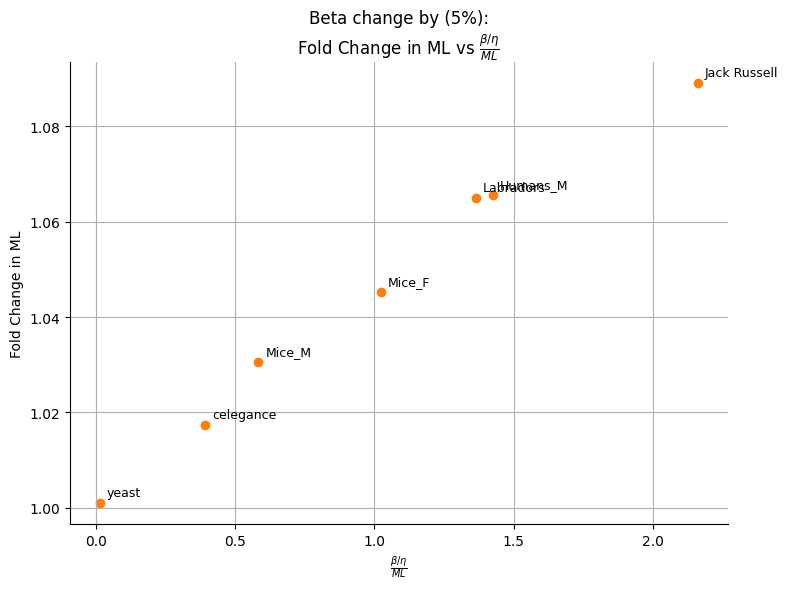

In [91]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Beta change params
x = []
y = []
labels = []

for preset in MLs_vs_beta_change:
    x.append(beta_eta_ratios[preset])
    y.append(MLs_vs_beta_change[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C1')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title(f'Beta change by ({int(beta_change_percent*100)}%):\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Eta change
Changing eta by 5%

In [114]:

# For each preset, save ML and remaining lifespan ratios for a single 5% eta change intervention at ML/2
eta_change_percent = -0.05
beta_eta_ratios = {}
MLs_vs_eta_change = {}
remaining_lifespan_ratios_medians_eta = {}
remaining_lifespan_ratios_means_eta = {}

for preset in my_presets:
    config_eta = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_eta['time_step_multiplier'] = int(np.ceil(config_eta['time_step_multiplier'] / 5))
    theta_eta = presets.getTheta(preset)
    beta_eta_ratio = theta_eta[1] / theta_eta[0]
    # Get baseline ML
    sim_eta = isr.getInterventionSR(
        theta_eta,
        parallel=True,
        nsteps=config_eta['nsteps'],
        time_step_multiplier=config_eta['time_step_multiplier'],
        npeople=config_eta['npeople'],
        t_end=config_eta['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_eta = sim_eta.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_eta

    # Only one intervention time: ML/2
    t_int_eta = 0.5 * ML_eta
    MLs_eta = []
    remaining_lifespan_ratios_medians_eta[preset] = []
    remaining_lifespan_ratios_means_eta[preset] = []

    sim_int_eta = isr.getInterventionSR(
        theta_eta,
        parallel=True,
        nsteps=int(config_eta['nsteps']*factor),
        time_step_multiplier=config_eta['time_step_multiplier'],
        npeople=config_eta['npeople'],
        t_end=config_eta['t_end']*factor,
        intervention_time=t_int_eta,
        intervention_duration=[0, config_eta['t_end']*factor],
        intervention_type='Eta change',
        intervention_effect=eta_change_percent
    )
    stats_eta = sim_eta.remaining_lifetime_at_age(age=t_int_eta, types=['median', 'mean'])
    stats_int_eta = sim_int_eta.remaining_lifetime_at_age(age=t_int_eta, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_eta[preset].append(stats_int_eta['median'] / stats_eta['median'])
    remaining_lifespan_ratios_means_eta[preset].append(stats_int_eta['mean'] / stats_eta['mean'])
    MLs_eta.append(sim_int_eta.getMedianLifetime())

    MLs_vs_eta_change[preset] = sim_int_eta.getMedianLifetime() / ML_eta
    remaining_lifespan_ratios_medians_eta[preset] = np.array(remaining_lifespan_ratios_medians_eta[preset])
    remaining_lifespan_ratios_means_eta[preset] = np.array(remaining_lifespan_ratios_means_eta[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [115]:
print(beta_eta_ratios)
print(MLs_vs_eta_change)

{'yeast': 0.014448063692353913, 'celegance': 0.39308677685950416, 'Mice_F': 1.0223179565563516, 'Mice_M': 0.5779094860380413, 'Labradors': 1.3566408477324614, 'Jack Russell': 2.141364796987288, 'Humans_M': 1.4271678555786171}
{'yeast': 1.0120250523413636, 'celegance': 1.0336361453455274, 'Mice_F': 1.0357548867314004, 'Mice_M': 1.0201666980661497, 'Labradors': 1.0425441195189662, 'Jack Russell': 1.036545528999705, 'Humans_M': 1.0497077832599901}


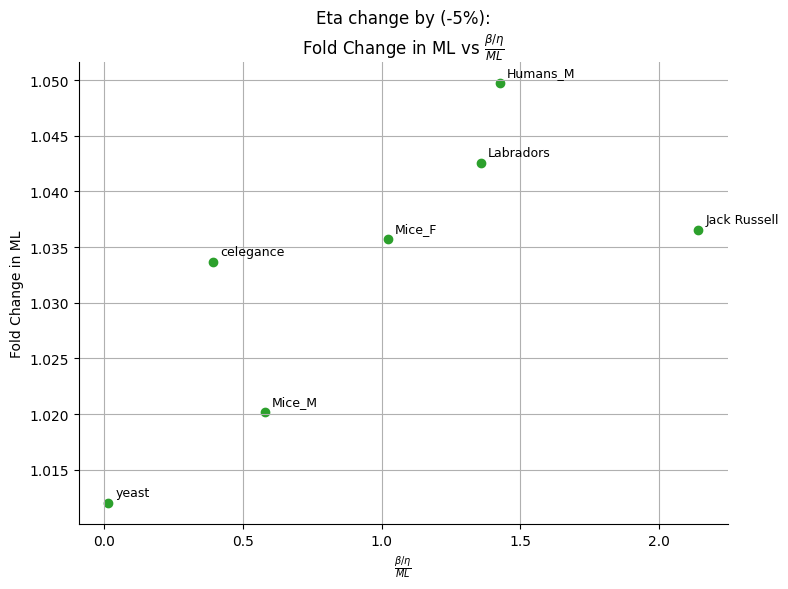

In [116]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Eta change params
x = []
y = []
labels = []

for preset in MLs_vs_eta_change:
    x.append(beta_eta_ratios[preset])
    y.append(MLs_vs_eta_change[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C2')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title(f'Eta change by ({int(eta_change_percent*100)}%):\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Xc change
Changing Xc by 5%

In [117]:

# For each preset, save ML and remaining lifespan ratios for a single 5% Xc change intervention at ML/2
xc_change_percent = 0.05
beta_eta_ratios = {}
MLs_vs_xc_change = {}
remaining_lifespan_ratios_medians_xc = {}
remaining_lifespan_ratios_means_xc = {}

for preset in my_presets:
    config_xc = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_xc['time_step_multiplier'] = int(np.ceil(config_xc['time_step_multiplier'] / 5))
    theta_xc = presets.getTheta(preset)
    beta_eta_ratio = theta_xc[1] / theta_xc[0]
    # Get baseline ML
    sim_xc = isr.getInterventionSR(
        theta_xc,
        parallel=True,
        nsteps=config_xc['nsteps'],
        time_step_multiplier=config_xc['time_step_multiplier'],
        npeople=config_xc['npeople'],
        t_end=config_xc['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_xc = sim_xc.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_xc

    # Only one intervention time: ML/2
    t_int_xc = 0.5 * ML_xc
    MLs_xc = []
    remaining_lifespan_ratios_medians_xc[preset] = []
    remaining_lifespan_ratios_means_xc[preset] = []

    sim_int_xc = isr.getInterventionSR(
        theta_xc,
        parallel=True,
        nsteps=int(config_xc['nsteps']*factor),
        time_step_multiplier=config_xc['time_step_multiplier'],
        npeople=config_xc['npeople'],
        t_end=config_xc['t_end']*factor,
        intervention_time=t_int_xc,
        intervention_duration=[0, config_xc['t_end']*factor],
        intervention_type='Xc change',
        intervention_effect=xc_change_percent
    )
    stats_xc = sim_xc.remaining_lifetime_at_age(age=t_int_xc, types=['median', 'mean'])
    stats_int_xc = sim_int_xc.remaining_lifetime_at_age(age=t_int_xc, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_xc[preset].append(stats_int_xc['median'] / stats_xc['median'])
    remaining_lifespan_ratios_means_xc[preset].append(stats_int_xc['mean'] / stats_xc['mean'])
    MLs_xc.append(sim_int_xc.getMedianLifetime())

    MLs_vs_xc_change[preset] = sim_int_xc.getMedianLifetime() / ML_xc
    remaining_lifespan_ratios_medians_xc[preset] = np.array(remaining_lifespan_ratios_medians_xc[preset])
    remaining_lifespan_ratios_means_xc[preset] = np.array(remaining_lifespan_ratios_means_xc[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [118]:
print(beta_eta_ratios)
print(MLs_vs_xc_change)

{'yeast': 0.01453210848379542, 'celegance': 0.3949699776429256, 'Mice_F': 1.0289883003663005, 'Mice_M': 0.5831009963250308, 'Labradors': 1.363094895533282, 'Jack Russell': 2.144582958690004, 'Humans_M': 1.4229517023863612}
{'yeast': 1.048052802245658, 'celegance': 1.0223002704903263, 'Mice_F': 1.0304944734389494, 'Mice_M': 1.0358639624796033, 'Labradors': 1.0379897782755432, 'Jack Russell': 1.0768743917884573, 'Humans_M': 1.0315412611391022}


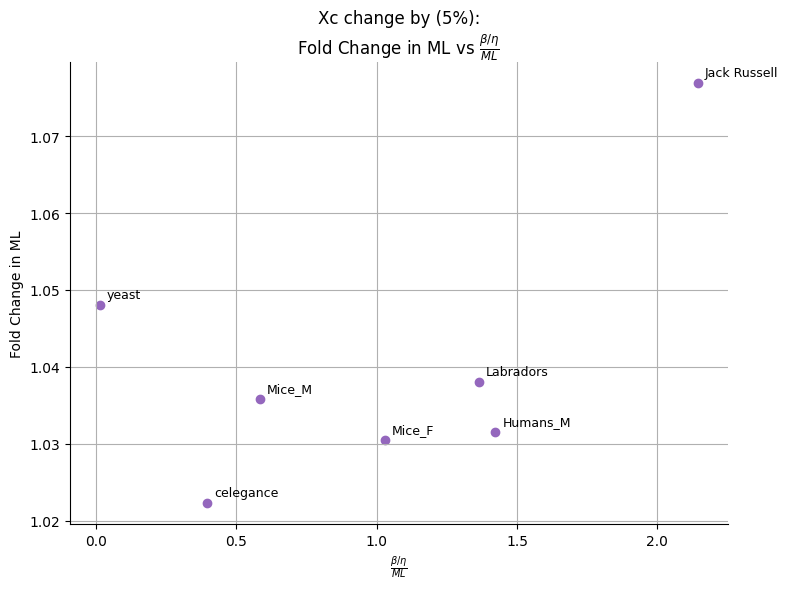

In [119]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Xc change params
x = []
y = []
labels = []

for preset in MLs_vs_xc_change:
    x.append(beta_eta_ratios[preset])
    y.append(MLs_vs_xc_change[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C4')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title(f'Xc change by ({int(xc_change_percent*100)}%):\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Epsilon change
Changing Epsilon by 5%

In [120]:

# For each preset, save ML and remaining lifespan ratios for a single 5% epsilon change intervention at ML/2
epsilon_change_percent = -0.05
beta_eta_ratios = {}
MLs_vs_epsilon_change = {}
remaining_lifespan_ratios_medians_epsilon = {}
remaining_lifespan_ratios_means_epsilon = {}

for preset in my_presets:
    config_epsilon = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_epsilon['time_step_multiplier'] = int(np.ceil(config_epsilon['time_step_multiplier'] / 5))
    theta_epsilon = presets.getTheta(preset)
    beta_eta_ratio = theta_epsilon[1] / theta_epsilon[0]
    # Get baseline ML
    sim_epsilon = isr.getInterventionSR(
        theta_epsilon,
        parallel=True,
        nsteps=config_epsilon['nsteps'],
        time_step_multiplier=config_epsilon['time_step_multiplier'],
        npeople=config_epsilon['npeople'],
        t_end=config_epsilon['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_epsilon = sim_epsilon.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_epsilon

    # Only one intervention time: ML/2
    t_int_epsilon = 0.5 * ML_epsilon
    MLs_epsilon = []
    remaining_lifespan_ratios_medians_epsilon[preset] = []
    remaining_lifespan_ratios_means_epsilon[preset] = []

    sim_int_epsilon = isr.getInterventionSR(
        theta_epsilon,
        parallel=True,
        nsteps=int(config_epsilon['nsteps']*factor),
        time_step_multiplier=config_epsilon['time_step_multiplier'],
        npeople=config_epsilon['npeople'],
        t_end=config_epsilon['t_end']*factor,
        intervention_time=t_int_epsilon,
        intervention_duration=[0, config_epsilon['t_end']*factor],
        intervention_type='Epsilon change',
        intervention_effect=epsilon_change_percent
    )
    stats_epsilon = sim_epsilon.remaining_lifetime_at_age(age=t_int_epsilon, types=['median', 'mean'])
    stats_int_epsilon = sim_int_epsilon.remaining_lifetime_at_age(age=t_int_epsilon, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_epsilon[preset].append(stats_int_epsilon['median'] / stats_epsilon['median'])
    remaining_lifespan_ratios_means_epsilon[preset].append(stats_int_epsilon['mean'] / stats_epsilon['mean'])
    MLs_epsilon.append(sim_int_epsilon.getMedianLifetime())

    MLs_vs_epsilon_change[preset] = sim_int_epsilon.getMedianLifetime() / ML_epsilon
    remaining_lifespan_ratios_medians_epsilon[preset] = np.array(remaining_lifespan_ratios_medians_epsilon[preset])
    remaining_lifespan_ratios_means_epsilon[preset] = np.array(remaining_lifespan_ratios_means_epsilon[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [121]:
print(beta_eta_ratios)
print(MLs_vs_epsilon_change)

{'yeast': 0.014478512720156555, 'celegance': 0.3947178423236514, 'Mice_F': 1.0254667798311659, 'Mice_M': 0.5814390635179154, 'Labradors': 1.3635273494976008, 'Jack Russell': 2.145872933401998, 'Humans_M': 1.4250566605259858}
{'yeast': 1.007835853350872, 'celegance': 1.0063277414197918, 'Mice_F': 1.0170437509395502, 'Mice_M': 1.0174403004005312, 'Labradors': 1.0322915728865372, 'Jack Russell': 1.0516591986700985, 'Humans_M': 1.0253754149468448}


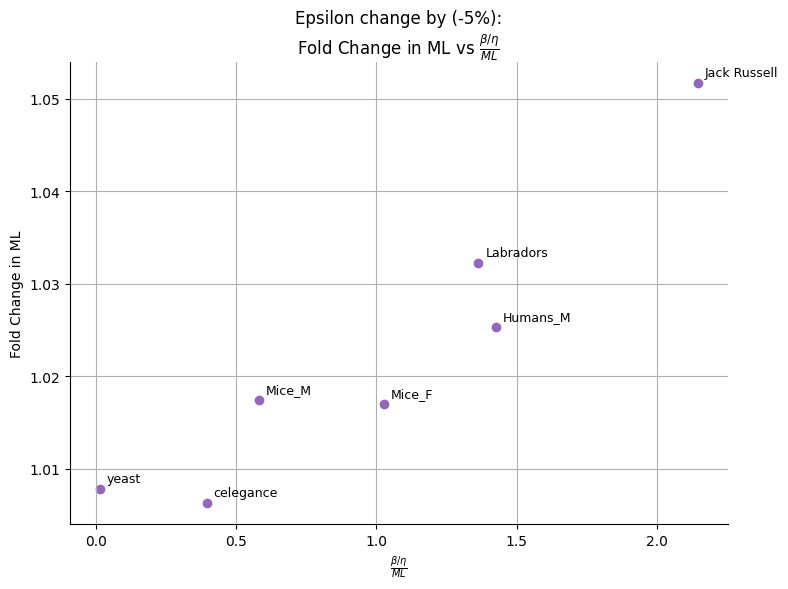

In [122]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Epsilon change params
x = []
y = []
labels = []

for preset in MLs_vs_epsilon_change:
    x.append(beta_eta_ratios[preset])
    y.append(MLs_vs_epsilon_change[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C4')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title(f'Epsilon change by ({int(epsilon_change_percent*100)}%):\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# -Alpha*x term
Add a -alpha*x term with alpha = 0.1

In [123]:

# For each preset, save ML and remaining lifespan ratios for a single alpha intervention at ML/2
alpha_value = 0.01
beta_eta_ratios = {}
MLs_vs_alpha = {}
remaining_lifespan_ratios_medians_alpha = {}
remaining_lifespan_ratios_means_alpha = {}

for preset in my_presets:
    config_alpha = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_alpha['time_step_multiplier'] = int(np.ceil(config_alpha['time_step_multiplier'] / 5))
    theta_alpha = presets.getTheta(preset)
    beta_eta_ratio = theta_alpha[1] / theta_alpha[0]
    # Get baseline ML
    sim_alpha = isr.getInterventionSR(
        theta_alpha,
        parallel=True,
        nsteps=config_alpha['nsteps'],
        time_step_multiplier=config_alpha['time_step_multiplier'],
        npeople=config_alpha['npeople'],
        t_end=config_alpha['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_alpha = sim_alpha.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_alpha

    # Only one intervention time: ML/2
    t_int_alpha = 0.5 * ML_alpha
    MLs_alpha = []
    remaining_lifespan_ratios_medians_alpha[preset] = []
    remaining_lifespan_ratios_means_alpha[preset] = []

    sim_int_alpha = isr.getInterventionSR(
        theta_alpha,
        parallel=True,
        nsteps=int(config_alpha['nsteps']*factor),
        time_step_multiplier=config_alpha['time_step_multiplier'],
        npeople=config_alpha['npeople'],
        t_end=config_alpha['t_end']*factor,
        intervention_time=t_int_alpha,
        intervention_duration=[0, config_alpha['t_end']*factor],
        intervention_type='Alpha',
        intervention_effect=alpha_value
    )
    stats_alpha = sim_alpha.remaining_lifetime_at_age(age=t_int_alpha, types=['median', 'mean'])
    stats_int_alpha = sim_int_alpha.remaining_lifetime_at_age(age=t_int_alpha, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_alpha[preset].append(stats_int_alpha['median'] / stats_alpha['median'])
    remaining_lifespan_ratios_means_alpha[preset].append(stats_int_alpha['mean'] / stats_alpha['mean'])
    MLs_alpha.append(sim_int_alpha.getMedianLifetime())

    MLs_vs_alpha[preset] = sim_int_alpha.getMedianLifetime() / ML_alpha
    remaining_lifespan_ratios_medians_alpha[preset] = np.array(remaining_lifespan_ratios_medians_alpha[preset])
    remaining_lifespan_ratios_means_alpha[preset] = np.array(remaining_lifespan_ratios_means_alpha[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [124]:
print(beta_eta_ratios)
print(MLs_vs_alpha)

{'yeast': 0.01453210848379542, 'celegance': 0.3947178423236514, 'Mice_F': 1.0304036900504354, 'Mice_M': 0.581675902240326, 'Labradors': 1.3600753815241893, 'Jack Russell': 2.1640969073587026, 'Humans_M': 1.4280140861481865}
{'yeast': 1.0729057193523917, 'celegance': 1.0232434947643045, 'Mice_F': 1.2268783017928293, 'Mice_M': 2.257690597714454, 'Labradors': 1.000566193635945, 'Jack Russell': 1.0041793258209375, 'Humans_M': 1.0011191333071112}


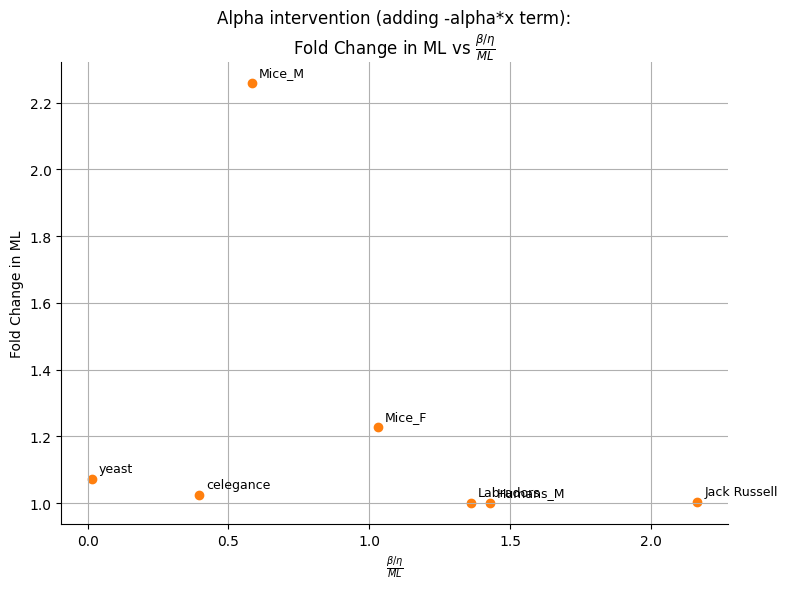

In [125]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Alpha intervention params
x = []
y = []
labels = []

for preset in MLs_vs_alpha:
    x.append(beta_eta_ratios[preset])
    y.append(MLs_vs_alpha[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C1')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel(r'$\frac{\beta/\eta}{ML}$')
plt.ylabel('Fold Change in ML')
plt.title('Alpha intervention (adding -alpha*x term):\n'+r'Fold Change in ML vs $\frac{\beta/\eta}{ML}$')
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

# Saturating Eta 
change eta by 5% of eta-eta_min

In [146]:

# For each preset, save ML and remaining lifespan ratios for a single Saturating_eta intervention at ML/2
saturating_eta_effect = -0.05  # 5% of (eta-eta_min)
beta_eta_ratios = {}
MLs_vs_saturating_eta = {}
remaining_lifespan_ratios_medians_saturating_eta = {}
remaining_lifespan_ratios_means_saturating_eta = {}
ML_sat_eta_dict = {}

for preset in my_presets:
    config_sat_eta = presets.get_config_params(preset, config_params=['nsteps', 'time_step_multiplier', 'npeople', 't_end'])
    config_sat_eta['time_step_multiplier'] = int(np.ceil(config_sat_eta['time_step_multiplier'] / 5))
    theta_sat_eta = presets.getTheta(preset)
    beta_eta_ratio = theta_sat_eta[1] / theta_sat_eta[0]
    # Get baseline ML
    sim_sat_eta = isr.getInterventionSR(
        theta_sat_eta,
        parallel=True,
        nsteps=config_sat_eta['nsteps'],
        time_step_multiplier=config_sat_eta['time_step_multiplier'],
        npeople=config_sat_eta['npeople'],
        t_end=config_sat_eta['t_end'],
        intervention_time=0,
        intervention_duration=0,
        intervention_type='Transient',
        intervention_effect=0
    )
    ML_sat_eta = sim_sat_eta.getMedianLifetime()
    beta_eta_ratios[preset] = beta_eta_ratio / ML_sat_eta

    # Only one intervention time: ML/2
    t_int_sat_eta = 0.5 * ML_sat_eta
    MLs_sat_eta = []
    remaining_lifespan_ratios_medians_saturating_eta[preset] = []
    remaining_lifespan_ratios_means_saturating_eta[preset] = []

    sim_int_sat_eta = isr.getInterventionSR(
        theta_sat_eta,
        parallel=True,
        nsteps=int(config_sat_eta['nsteps']*factor),
        time_step_multiplier=config_sat_eta['time_step_multiplier'],
        npeople=config_sat_eta['npeople'],
        t_end=config_sat_eta['t_end']*factor,
        intervention_time=t_int_sat_eta,
        intervention_duration=[0, config_sat_eta['t_end']*factor],
        intervention_type='Saturating_eta',
        intervention_effect=[saturating_eta_effect, time_units[preset]]
    )
    stats_sat_eta = sim_sat_eta.remaining_lifetime_at_age(age=t_int_sat_eta, types=['median', 'mean'])
    stats_int_sat_eta = sim_int_sat_eta.remaining_lifetime_at_age(age=t_int_sat_eta, types=['median', 'mean'])
    remaining_lifespan_ratios_medians_saturating_eta[preset].append(stats_int_sat_eta['median'] / stats_sat_eta['median'])
    remaining_lifespan_ratios_means_saturating_eta[preset].append(stats_int_sat_eta['mean'] / stats_sat_eta['mean'])
    MLs_sat_eta.append(sim_int_sat_eta.getMedianLifetime())
    ML_sat_eta_dict[preset] = sim_int_sat_eta.getMedianLifetime()*time_convert[time_units[preset]]

    MLs_vs_saturating_eta[preset] = sim_int_sat_eta.getMedianLifetime() / ML_sat_eta
    remaining_lifespan_ratios_medians_saturating_eta[preset] = np.array(remaining_lifespan_ratios_medians_saturating_eta[preset])
    remaining_lifespan_ratios_means_saturating_eta[preset] = np.array(remaining_lifespan_ratios_means_saturating_eta[preset])

Converting time units: days -> generations (s=0.125)
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_F' -> 'mice_F'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Mice_M' -> 'mice_M'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Using alias 'Labradors' -> 'Labradors_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Using alias 'Jack Russell' -> 'Jack_Russell_vetCompass'
Converting time units: days -> years (s=365.0)
Using alias 'Humans_M' -> 'humans_M_combined'
Using alias 'Humans_M' -> 'humans_M_combined'
Converting time units: days -> years (s=365.0)


In [147]:
print(beta_eta_ratios)
print(MLs_vs_saturating_eta)

{'yeast': 0.01455519975786925, 'celegance': 0.39434024234693876, 'Mice_F': 1.0275767937814357, 'Mice_M': 0.5783776184690158, 'Labradors': 1.3635273494976008, 'Jack Russell': 2.152995625697539, 'Humans_M': 1.4284375778700569}
{'yeast': 1.0200591011004858, 'celegance': 1.035019019970473, 'Mice_F': 1.0414257566303766, 'Mice_M': 1.0209930785425094, 'Labradors': 1.0443466066203075, 'Jack Russell': 1.0355374681621201, 'Humans_M': 1.029883877755468}


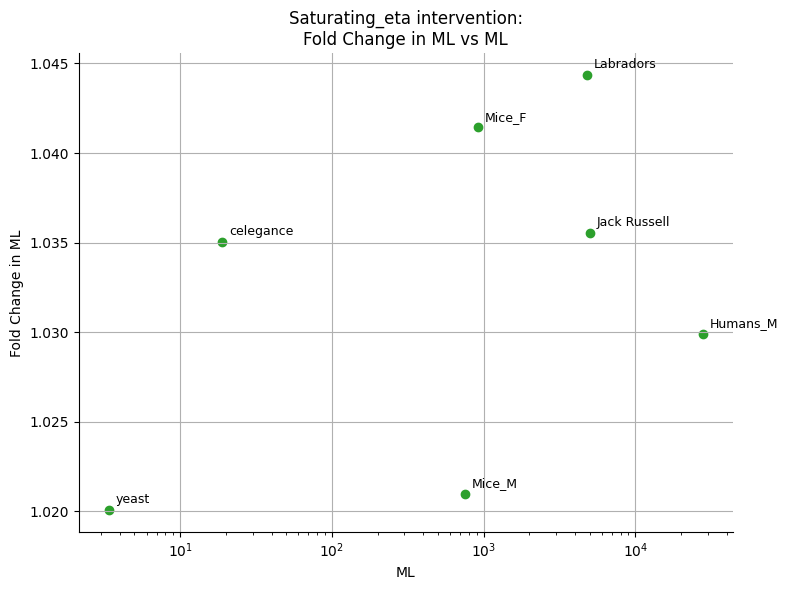

In [148]:
import matplotlib.pyplot as plt

# Prepare data for plotting using Saturating_eta intervention params
x = []
y = []
labels = []

for preset in MLs_vs_saturating_eta:
    x.append(ML_sat_eta_dict[preset])  # x axis is ML
    y.append(MLs_vs_saturating_eta[preset])
    labels.append(str(preset))

plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C2')

# Annotate each point with its preset label
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.xlabel('ML')
plt.ylabel('Fold Change in ML')
plt.title('Saturating_eta intervention:\nFold Change in ML vs ML')
plt.xscale('log')  # Set x-axis to log scale
plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()